In [1]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
from pinns.samplers import RandomSampler, ConstantSampler, DataSampler

path = './'


''' -- CONSTRAINTS -- '''


def get_data(path):
    init = torch.tensor(np.load(path + 'init_data.npy'))
    left = torch.tensor(np.load(path + 'left_data.npy'))
    right = torch.tensor(np.load(path + 'right_data.npy'))
    
    return ([init[:,  :2], left[:,  :2], right[:,  :2]], 
            [init[:, [2]], left[:, [2]], right[:, [2]]])

pts, data = get_data(path)
constraints_sampler = ConstantSampler((pts, data))


''' -- COLLOCATION -- '''


domain = {'t': [0, 1], 'x': [-1, 1]}
collocation_sampler = RandomSampler(domain, 2048, return_dict=True)


''' -- VALIDATION DATA -- '''

# We do not want to load all test points every time, so let's 
# write sampler that gives us either all data points or random 
# subset of them. 1024 is pretty much enough to fine precision.

test_data_sampler = DataSampler(path + 'solution.npy', 512, 2)

Now it's time to write loss function. Remember: we should return tuple of losses, so if you want, for example, multiply loss along each boundary, or multiply sum of boundary losses - you should just be sure that number of returned elements and number of loss coefficients are the same.

In [4]:
from pinns.derivatives import Derivative

d = Derivative(method='autograd')

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred,
    D = 0.001
    ):
    
    # We do not need left and right because we are solving 
    # Dirichlet problem and we just compare predictions and 
    # solution. If we solve Cauchy or Robin problem, we 
    # need to calculate derivatives at boundary points.
    
    init_pts, left_pts, right_pts = cstr_pts
    init_pred, left_pred, right_pred = cstr_pred
    init_vals, left_vals, right_vals = cstr_vals
    
    # If we use RandomSampler, we are unable to split values
    # like that. But it is just for clarity.
    
    t, x = coll_pts['t'], coll_pts['x']
    
    def initial_loss():
        return torch.mean(torch.square(init_pred - init_vals))
    
    def left_loss():
        return torch.mean(torch.square(left_pred - left_vals))
    
    def right_loss():
        return torch.mean(torch.square(right_pred - right_vals))
    
    def pde_loss(u, t, x):
        ut  = d(u,  t)
        uxx = d(u,  x, orders = 2)
        
        return torch.mean(torch.square(ut - D * uxx - 5 * (u - u**3)))
    
    return (
        initial_loss(), 
        left_loss(), 
        right_loss(), 
        pde_loss(coll_pred, t, x)
    )

We will make callback to visualize training process (this will took very long):

In [5]:
# We know the shape of test data.
Nt, Nx = 101, 201
pts, values = test_data_sampler(full=True)

pts = [
    pts[:,0].reshape(Nt, Nx),
    pts[:,1].reshape(Nt, Nx)
]
values = values.reshape(Nt, Nx)

In [6]:
from pinns import Trainer
from pinns.models import KAN
from pinns.activations import Swish
from pinns.optimizers import Adam
from pinns.errors import l2 as metric

pinn = KAN([2] + [5, 3] + [1], type = 'efficient', grid_size = 15)

adam = Adam(pinn, lr = 1e-2)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs = [0.75]*3 + [0.25],
    test_points_sampler = test_data_sampler
)

trainer.train(
    num_iters=1000,
    optimizers=[(0, adam)],
    validate_every=1,
    error_metric=metric
    )

trainer.evaluate(metric, full = True)

  0%|          | 0/1000 [00:00<?, ?it/s]

55.837387

If we are using L2 error, we need to be aware that if number of points increases, then error will be too. Because of that, we might prefer RMSE metric.

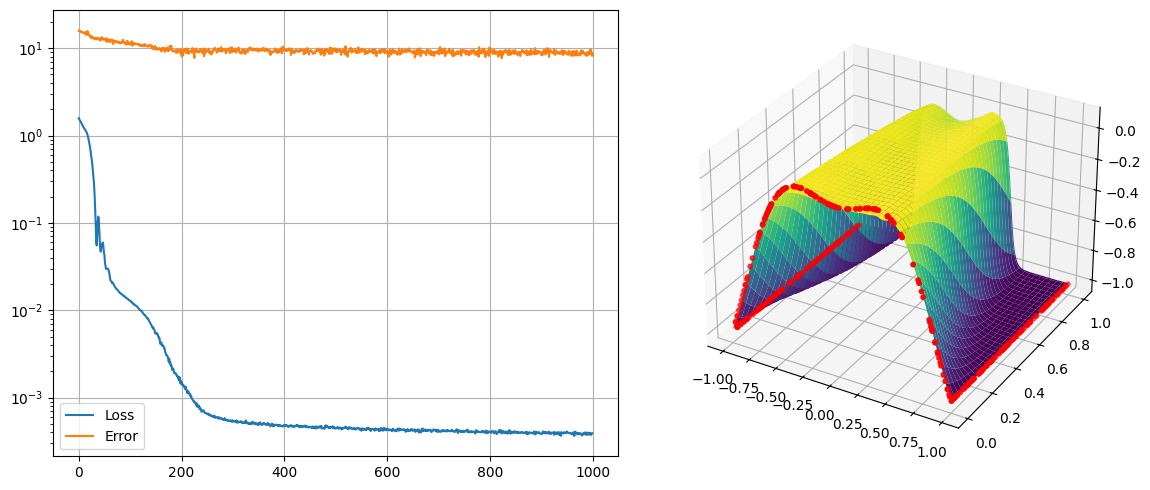

In [7]:
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121)
ax.plot(trainer.loss_history, label='Loss')
ax.plot(range(0, trainer.iter + 1, 1), trainer.error_history, label='Error')
ax.grid()
ax.set_yscale('log')
ax.legend()

preds = pinn.predict(test_data_sampler(full=True)[0]).detach().reshape(Nt, Nx)

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(pts[1], pts[0], preds, cmap='viridis')
# ax.plot_surface(pts[1], pts[0], values, cmap='viridis')

cstr_pts, cstr_vals = constraints_sampler()
stacked_pts = torch.cat([torch.hstack([t[:, [1]], t[:, [0]]]) for t in cstr_pts])
stacked_vals = torch.cat(cstr_vals)
constraints = torch.hstack([stacked_pts, stacked_vals.reshape(-1, 1)]).T

ax.scatter3D(*constraints, color='r', s=10)
# ax.view_init(80, -120)

plt.tight_layout()
plt.show()

In [9]:
from PIL import Image
import imageio
from tqdm.notebook import tqdm_notebook as tqdm

def save_animation(images, path, duration=5, fps=60, loop=0, type='mp4'):
    
    fig = plt.figure(figsize=(6, 6))
    
    if type == 'mp4':
        
        writer = imageio.get_writer('./training.mp4', fps=10)

        for file in tqdm(images):
            predictions = np.load(file)
            ax = fig.add_subplot(111, projection='3d')
            # Set plot limits and labels
            ax.set_xlim(-1, 1)
            ax.set_ylim(0, 1)
            surface = ax.plot_surface(pts[1], pts[0], predictions, cmap='viridis')
            scatter = ax.scatter3D(*constraints, color='r', s=10)
            fig.savefig('./frame.png', dpi=300)
            writer.append_data(imageio.imread('./frame.png'))
            fig.clear()
        writer.close()
        
    if type == 'gif':
        
        imgs = []
        
        for file in tqdm(images):
            predictions = np.load(file)
            ax = fig.add_subplot(111, projection='3d')
            # Set plot limits and labels
            ax.set_xlim(-1, 1)
            ax.set_ylim(0, 1)
            surface = ax.plot_surface(pts[1], pts[0], predictions, cmap='viridis')
            scatter = ax.scatter3D(*constraints, color='r', s=10)
            fig.savefig(f'./{file}.png', dpi=300)
            fig.clear()
            imgs.append(Image.open(f'./{file}.png'))
        imgs[0].save(path, save_all=True, append_images=imgs[1:], duration=duration, fps=fps, loop=loop)
        
files = [f'./.temp/{i}.npy' for i in range(0, trainer.iter, save_every)]
save_animation(files, './animation.gif', type='gif')

NameError: name 'save_every' is not defined